In [1]:
!pip install -q efficientnet >> /dev/null

import random, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, math
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import glob

In [2]:
DEVICE = "TPU" #or "GPU"

SEED = 16

train_fold = 4

FOLDS = 5

img_size = (896, 896)

batch_size = 16 
EPOCHS = 30


EFF_NET = 3
weights = 'noisy-student' #'noisy-student' 'imagenet'

add_old_one = False


def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)


if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path('setitraintfrecords')
files_all = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train_*.tfrec')))
files_all

array(['gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_0_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_10_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_11_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_12_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_13_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_14_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_15_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_16_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_17_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a89366676f5fc4afbbfc61cdeb9602745afb/train_18_3000.tfrec',
       'gs://kds-dfd63dec37700a6b8de1a893

In [4]:
def mixup(image, label):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    
    imgs = []; labs = []
    for j in range(batch_size * REPLICAS):
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([], 0, batch_size), tf.int32)
        p = tf.random.uniform([], 0.15, 0.35) 
        
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        
        lab1 =  tf.cast(label[j], tf.float32)
        lab2 =  tf.cast(label[k], tf.float32)
        
        imgs.append((1-p)*img1 + p*img2)
        labs.append((1-p)*lab1 + p*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(batch_size * REPLICAS, img_size[0], img_size[1], 3))
    label2 = tf.reshape(tf.stack(labs),(batch_size * REPLICAS, 1))
    
    return image2,label2

def prepare_image(img, augment=True, dim=256):    
    img = tf.io.decode_raw(img, tf.float16)
    img = tf.reshape(img, [273, 256, 3])
    img = tf.cast(img, tf.float32)
    
    img = tf.clip_by_value(img, clip_value_min=-6.0, clip_value_max=6.0)
    img = img / 3.0
    
    #img = tf.image.resize(img, [img_resize[0], img_resize[1]])
    
    img = tf.unstack(img, axis = 2)
    img = tf.concat(img, axis = 0)
    img = tf.expand_dims(img, 2)
    img = tf.image.grayscale_to_rgb(img)
    
    img = tf.image.resize(img, [img_size[0], img_size[1]])
    
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        
        #if tf.random.uniform(shape=[]) < 0.25:
        #    r_int =  tf.random.uniform(shape=(), minval=32 , maxval=64 , dtype=tf.int32)
        #    r_int = r_int - (r_int % 2)
        #    img = tfa.image.random_cutout(tf.expand_dims(img, 0), (r_int, dim[0] - 2))
        #    img = tf.squeeze(img)
            
        #if tf.random.uniform(shape=[]) < 0.125:
        #    r_int = tf.random.uniform(shape=(), minval=32 , maxval=64 , dtype=tf.int32)
        #    r_int = r_int - (r_int % 2)
        #    img = tfa.image.random_cutout(tf.expand_dims(img, 0), (r_int, dim[0] - 2))
        #    img = tf.squeeze(img)

                      
    img = tf.reshape(img, [dim[0], dim[1], 3])
            
    return img

def count_data_items(filenames):
    n = [int(filename.split('_')[-1].split('.')[0]) for filename in filenames]
    return np.sum(n)


def read_labeled_tfrecord(example):
    tfrec_format = {
        'signal'   : tf.io.FixedLenFeature([], tf.string),
        'id'       : tf.io.FixedLenFeature([], tf.string),
        'target'   : tf.io.FixedLenFeature([], tf.int64),
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['signal'], example['target']


def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    
    if augment:
        ds = ds.map(mixup, num_parallel_calls = AUTO)
        
    return ds


EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6]

def build_model(dim=128, ef=0):
    inp = tf.keras.layers.Input(shape=(dim[0],dim[1],3))
    
    base = EFNS[ef](input_shape=(dim[0],dim[1],3), weights=weights,include_top=False)
    x = base(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inp,outputs=x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy() #label_smoothing=0.05
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model


def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.0000025 * REPLICAS * batch_size * 2
    lr_min     = 0.000005
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

#########################
#### FOLD 5
#########################
43933696/43933088 [==============================] - 1s 0us/step
Epoch 1/30
375/375 [==============================] - 486s 1s/step - loss: 0.4872 - auc: 0.4907 - val_loss: 0.3417 - val_auc: 0.5163
Epoch 2/30
375/375 [==============================] - 372s 992ms/step - loss: 0.3307 - auc: 0.5197 - val_loss: 0.2416 - val_auc: 0.7817
Epoch 3/30
375/375 [==============================] - 373s 994ms/step - loss: 0.2862 - auc: 0.6808 - val_loss: 0.2109 - val_auc: 0.8291
Epoch 4/30
375/375 [==============================] - 373s 996ms/step - loss: 0.2755 - auc: 0.7073 - val_loss: 0.1895 - val_auc: 0.8568
Epoch 5/30
375/375 [==============================] - 373s 995ms/step - loss: 0.2605 - auc: 0.7382 - val_loss: 0.2048 - val_auc: 0.8541
Epoch 6/30
375/375 [==============================] - 374s 999ms/step - loss: 0.2683 - auc: 0.7211 - val_loss: 0.2020 - val_auc: 0.8573
Epoch 7/30
375/375 [==============================] - 374s

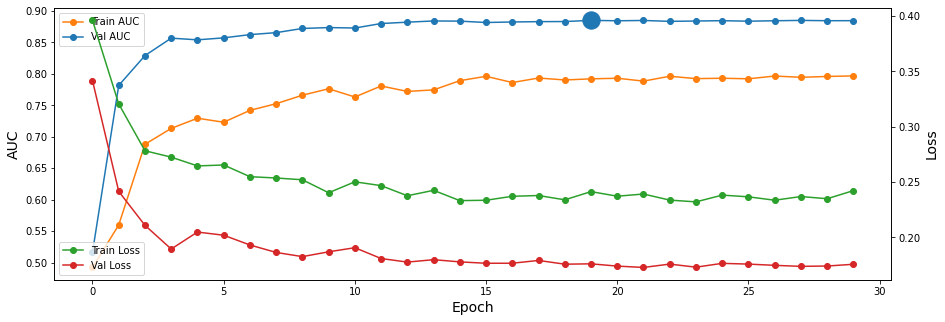

In [5]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 1
DISPLAY_PLOT = True

auc_ = []

skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
for fold,(idxT,idxV) in enumerate(skf.split(np.arange(len(files_all)))):
    
    if fold != train_fold:
        continue
    
    # DISPLAY FOLD INFO
    if DEVICE=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    print('#'*25); print('#### FOLD',fold+1)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    if add_old_one:
        files_train = tf.io.gfile.glob([files_all[x] for x in idxT] + [GCS_PATH + '/old_one_10012.tfrec'])
    else:
        files_train = tf.io.gfile.glob([files_all[x] for x in idxT])
    np.random.shuffle(files_train); print('#'*25)
    files_valid = tf.io.gfile.glob([files_all[x] for x in idxV])
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(dim=img_size ,ef=EFF_NET)
        
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_auc', verbose=0, save_best_only=True,
         save_weights_only=True, mode='max', save_freq='epoch')
   
    # TRAIN
    history = model.fit(
        get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                dim=img_size, batch_size = batch_size), 
        
        epochs=EPOCHS, callbacks = [sv,get_lr_callback(batch_size)], 
        steps_per_epoch=count_data_items(files_train)/batch_size//REPLICAS,
        validation_data=get_dataset(files_valid,augment=False,shuffle=False,
        repeat=False,dim=img_size), 
        verbose=VERBOSE)
    

    #model.load_weights('fold-%i.h5'%fold)
    print()
    print('--------------- MAX AUC :- ', np.max(history.history['val_auc']))
    print()
    auc_.append(np.max(history.history['val_auc']))
    
    # PLOT TRAINING
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(EPOCHS),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(EPOCHS),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=300,color='#1f77b4')
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(EPOCHS),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(EPOCHS),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.ylabel('Loss',size=14)
        plt.legend(loc=3)
        plt.show()